#Finding Relavant Hashtags in Instagram Data

Instagram is a network of pictures connected by people, geography, and hashtags. Pictures can make for a daunting dataset, but hashtags? They are small and easy to parse. There are a lot of them, though, and they are constantly evolving.

Fortunately, we can learn a little bit about hashtags and their meanings by analyzing how they are combined. For example, you might look at #beer and #craftbeer and realized that the latter is more associated with #milkstout and #ipa.

Let's take a look at #atlanta and see what we can learn about related hashtags. Rather than getting hung up on more complicated approaches, we'll stick with something simple. The following code walks through the process as we...

* Set up our environment
* Pull data from Instagram
* Convert posts into feature vectors that we can work with
* Quantify the relationships between tags using cosine similarity
* Combine hashtag similarity vectors
* Create a ranked list of posts that we might like based on similarity vectors for selected tags

<a id='setup'></a>
##Setting up the environment
We will use [scikit-learn](http://scikit-learn.org/stable/), [pandas](http://pandas.pydata.org/), [NumPy](http://www.numpy.org/), and [Instagram's official python library](https://github.com/Instagram/python-instagram).

In [1]:
from instagram.client import InstagramAPI
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image
from datetime import datetime, timedelta

Here is where you'll fill in your own credentials. Check out [Instagram's developer page](https://instagram.com/developer/) to get an account.

In [2]:
client=''
secret=''
api = InstagramAPI(client_id=client, client_secret=secret)

 <a id='pull_data'></a>
##Getting and processing the data
The last step of preparation is to get the data. The get_pics() function requires a hashtag and amount of history (in hours). It will them pull all posts that used that hashtag for approximately that time window. While it's at it, it saves a bunch of features that we don't use for this analysis. Here's what you'll get...

* Post ID
* Link to the post
* String of the included hashtags
* Post time
* Poster's user ID
* Comment count
* Like count
* Standard resolution image url
* Latitude
* Longitude

We don't use that info now, but you can use it to try other experiments with the data. There is also an add_follower_count() function that will append the current follower count for each user onto the library (and probably hit your [rate limit](https://instagram.com/developer/limits/) in the process).

In [3]:
def get_pics(tag, history_hours=12):
    library=[]
    media, _next =api.tag_recent_media(count=33, tag_name=tag)
    newest=media[0].created_time
    oldest=media[-1].created_time
    max_tag=_next.split('max_tag_id=')[1]
    while (oldest>newest-timedelta(hours=history_hours)):
        more_media, _next = api.tag_recent_media(count=33, tag_name=tag, max_tag_id=max_tag)
        media.extend(more_media)
        oldest=more_media[-1].created_time
        max_tag=_next.split('max_tag_id=')[1]
    for i in media:
        if (i.type=='image') & hasattr(i,'tags'):
            try:
                library+=[[i.id,i.link,get_tags(i.tags),i.created_time,i.user.id,i.comment_count,i.like_count, i.get_standard_resolution_url(), i.location.point.latitude, i.location.point.longitude]]
            except AttributeError:
                library+=[[i.id,i.link,get_tags(i.tags),i.created_time,i.user.id,i.comment_count,i.like_count, i.get_standard_resolution_url(), None, None]]
    library=pd.DataFrame(library, columns=['id','link','tags','time','user','comments','likes','pic_url','lat','lng'])
    return library

def get_tags(tags):
    return ''.join([str(i)[4:] for i in tags])

def add_follower_count(library):
    users=list(set(library.user))
    followers=[]
    for i in users:
        followers.append([i,api.user(i).counts['followed_by']])
    library=library.merge(pd.DataFrame(followers, columns=['user','followers']), on='user')

Let's get two weeks worth of pictures.

*Data was pulled at 10:09 PM EST, June 18th, 2015*

In [4]:
library=get_pics('atlanta', history_hours=336)
len(library)

122588

We got 123 thousand posts! That's great! Before we do anything, we should split our data into training and testing sets. We'll train on the first 5/7ths of the data, which is an approximation for the first 10 days.

It's very important to isolate your testing data before you do anything else. If you don't, information from your testing data might [leak](https://www.kaggle.com/wiki/Leakage) into your handling or analysis of the training data.

In [5]:
train_index=library.index[:int(len(library)*(5.0/7))]
train=library.ix[train_index]
test=library.drop(train_index)

Now that we've got our training data, what are the most used tags?

In [6]:
from collections import Counter
Counter([tag for tagset in train.tags for tag in tagset.split()]).most_common(10)

[('atlanta', 87507),
 ('atl', 19142),
 ('miami', 13957),
 ('newyork', 12594),
 ('fashion', 9119),
 ('georgia', 7998),
 ('chicago', 7928),
 ('love', 7512),
 ('california', 7113),
 ('houston', 6781)]

Well, that's not as great. Why do so many of the most popular tags have nothing to do with Atlanta?

In [7]:
train[train.tags.str.contains('miami') &
      train.tags.str.contains('chicago') &
      train.tags.str.contains('newyork')
     ].groupby('user').count().sort('id', ascending=False)['id'][:10]

user
1481714532    328
32491943      260
520006436     258
2095641100    166
455679198      79
230334463      77
207076101      58
1138983466     57
317666477      48
2062886227     47
Name: id, dtype: int64

Of course... spam. There are users who submit hundreds of posts with the same tags. We have one user that tagged 328 posts with #newyork, #miami, and #chicago, and others over 10 days. Should users who spam have a large influence on our results? Probably not, so let's assume that the top 5% of users by volume are spammers and cut them out of our training data. This might eliminate a few legitimate posters, but it's a compromise.

In [8]:
train_user_counts=train.groupby('user').count().sort('id',ascending=False)['id']
spammer_cutoff=train_user_counts.quantile(.95)
spammers=train_user_counts.index[train_user_counts>spammer_cutoff]
train=train[~train['user'].isin(list(spammers))]
print spammer_cutoff

11.0


We just cut out anybody who posted more than 11 time in our training data (~10 days). Now we'll turn our posts into feature vectors.

 <a id='countvectorize'></a>
##Creating features from text

The order of words is often important in text processing, so some people use [skip-grams](https://en.wikipedia.org/wiki/N-gram#Skip-gram) or continuous bag-of-words to capture it. We're working with hashtags, and we can probably assume that order is not important. This means we can use a normal [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model), which is a lot easier!

We'll be using scikit's [countvectorizer()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). It turns a set of documents into a matrix of numbers that represent the words used and not used in each document. This is called vectorization, and it is how we implement the bag of words. While we're at it, let's ignore anything that is used fewer than 25 times or in more than 90% of the posts. We'll also use binary flags to indicate the presence of a hashtag rather than counting the times that it appears in a post. Countvectorizer() is also case insensitive by default.

In [9]:
vectorizer = CountVectorizer(strip_accents='unicode', binary=True, min_df=25, max_df=.9)
train_counts=vectorizer.fit_transform(train['tags'])
test_counts=vectorizer.transform(test['tags'])
train_counts.shape

(50837, 3443)

So it looks like we are learning from 50.8 thousand posts with 3.4 thousand distinct possible hashtags. Luckily, countvectorizer() returns a space-saving [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). We also created test_counts, a representation of our testing data that we'll use later.

 <a id='similarity'></a>
##Calculating and checking hashtag similarities

Now comes the fun part. Calculating similarities between items with this kind of data is called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), and it can be done with hashtags, products, movies, etc. We'll be using a metric called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). There are others, from the basic [set overlap](https://en.wikipedia.org/wiki/Overlap_coefficient) and [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) to the more complicated [BM25](https://en.wikipedia.org/wiki/Okapi_BM25), but cosine similarity is simple and produces decent results. If you want to learn about the differences between various metrics, [this tutorial is very helpful](http://www.benfrederickson.com/distance-metrics/?hn=1&utm_source=hackernewsletter&utm_medium=email&utm_term=fav).

The cosine_frame() function uses scikit's cosine_similarity() function to return a dataframe of similarities with labeled rows and columns. The show_similar() function takes in a hashtag and shows what tags are similar to it. It also has a few other tricks up its sleeve that we'll get into later.

In [10]:
def cosine_frame(counts):
    features=vectorizer.get_feature_names()
    cosine_similarities=cosine_similarity(counts.transpose(),counts.transpose())
    return pd.DataFrame(cosine_similarities,columns=features, index=features)

def show_similar(tags, weights=None, subtract=None, subtract_multiplier=None, number=5):
    if weights==None:
        weights=[1 for i in range(len(tags))]
    combined=(similarities[tags].multiply(weights)).sum(axis=1)/sum(weights)
    if subtract!=None:
        if subtract_multiplier==None:
            subtract_multiplier=[1 for i in range(len(subtract))]
        bad_tags=similarities[subtract].multiply(subtract_multiplier).sum(axis=1)
        combined=combined-bad_tags
    combined.sort(ascending=False)
    print combined[0:1+number]

In [11]:
similarities=cosine_frame(train_counts)
similarities.shape

(3443, 3443)

Our similarity matrix has an NxN shape, where N is the number of hashtags we are considering. Each column (or row) is a vector of similarities between one hashtag and all the others. Individually and together, these similarity values give us an idea of how a hashtag is used and what it means.

To test these similarities, let's consider a topic that is close to my heart (and house), [Little Five Points](https://en.wikipedia.org/wiki/Little_Five_Points). This is a fun neighborhood with a few nicknames, so it would be great to know how people are tagging it on Instagram. Let's see which tags are the most similar to #l5p.

In [12]:
show_similar(['l5p'],number=10)

l5p                 1.000000
little5points       0.376036
littlefivepoints    0.284721
atlantatattoo       0.207413
bestofatlanta       0.203425
gatattooers         0.180151
henna               0.150061
bodyart             0.125245
grantpark           0.124214
atlantaartists      0.112594
nailtech            0.108687
dtype: float64


Not bad! The two most similar tags are #little5points and #littlefivepoints. We also have a lot of hashtags related to tattoo shops, of which there are plenty in Little Five, and [Grant Park](https://en.wikipedia.org/wiki/Grant_Park,_Atlanta), another cool neighborhood in Atlanta.

Now let's look up [The Tabernacle](https://en.wikipedia.org/wiki/The_Tabernacle), one of the best music venues in town.

In [13]:
show_similar(['tabernacle'],number=10)

tabernacle     1.000000
awolnation     0.434493
dangelo        0.317683
jodeci         0.220796
alternative    0.061473
grunge         0.061123
bands          0.055561
rock           0.053201
concert        0.044173
concerts       0.037483
favorite       0.036558
dtype: float64


These makes sense too! Awolnation played at the Tabernacle on the 13th, D'Angelo played on the 14th, and Jodeci played last night. We were able to identify those related tags and topics without actually understanding the text. That's pretty neat, but what can we do if we want to combine multiple hashtags?

 <a id='combine'></a>
##Combining similarity vectors

To combine vectors, all we have to do is average them. There are probably more complicated ways that you could do it, but this way is easy and can get useful results. Let's try it with [#weloveatl](http://www.weloveatl.org/), a tag that people use to express their appreciation for Atlanta, and #streetart, a tag that people might use on pictures of murals around town.

In [14]:
show_similar(['weloveatl'],number=10)

weloveatl            1.000000
discoveratl          0.406598
igersatlanta         0.328534
streetshootersatl    0.279871
whyiloveatl          0.262123
igersatl             0.253584
shootthiscity        0.253157
vsco                 0.249738
justgoshoot          0.236437
vscocam              0.231309
atlantacollective    0.230989
dtype: float64


In [15]:
show_similar(['streetart'], number=10)

streetart         1.000000
graffiti          0.321185
mural             0.270636
spraypaint        0.177568
urbanart          0.170023
wallart           0.162947
popart            0.151430
art               0.147551
paint             0.112401
dublin            0.090212
exploreatlanta    0.082865
dtype: float64


In [16]:
show_similar(['weloveatl','streetart'], number=10)

weloveatl            0.535648
streetart            0.535648
discoveratl          0.217187
graffiti             0.175716
igersatlanta         0.175073
mural                0.165302
streetshootersatl    0.164540
whyiloveatl          0.159227
shootthiscity        0.135905
igersatl             0.134966
justgoshoot          0.134509
dtype: float64


By combining the two vectors, we have a new list of hashtags that are related to the topics, emphasizing those that are similar to both over those that are only similar to one. But what if we wanted to focus more on #streetart and less on #weloveatl?

In [17]:
show_similar(['weloveatl','streetart'], weights=[.3,.7], number=10)

streetart            0.721389
weloveatl            0.349907
graffiti             0.233904
mural                0.207436
discoveratl          0.141422
spraypaint           0.127052
urbanart             0.123180
wallart              0.119118
streetshootersatl    0.118408
whyiloveatl          0.118068
art                  0.116381
dtype: float64


With a weighted average, we can shift our focus to one hashtag while still retaining elements of the other. You can even subtract similarity vectors, but I'll let you play with that on your own.

Now that we've calculated these similarity vectors, how do we use them? Let's see if we can rank posts based on how relevant they are to a couple of hashtags.

 <a id='rank'></a>
##Using hashtag similarities to find and rank posts

The make_scores() function allows us to take these similarity vectors and score each post in our training set with them. This is done by taking the dot product of a similarity vector we like and the feature set created from our testing data. In effect, we are giving a post more points for each hashtag it contains that is similar to the tags we picked.

But what about posts with more hashtags? Will they get higher scores? Yes, but we can change that. We could divide each score by the number of tags in the post, but then our top results would only contain the hashtags that we supply. I like the idea of giving some leeway to posts with more tags, so we'll use a special adjustment in the denominator that is stolen from [BM25](https://en.wikipedia.org/wiki/Okapi_BM25) weighting. By adjusting the parameter b from 0 to 1, you can apply different penalties to posts based on their hashtag count. If b=0, the number of tags doesn't matter. If b=1, the penalty term in the denominator is proportionate to the number of tags in the post. When it comes to picking a value for b, there is no right answer. Play around and see what you like.

In [18]:
def make_scores(tags, subtract=None, weights=None,subtract_multiplier=None, b=0):
    if weights==None:
        weights=[1 for i in range(len(tags))]
    combined=(similarities[tags].multiply(weights)).sum(axis=1)/sum(weights)
    if subtract!=None:
        if subtract_multiplier==None:
            subtract_multiplier=[1 for i in range(len(subtract))]
        bad_tags=similarities[subtract].multiply(subtract_multiplier).sum(axis=1)
        combined=combined-bad_tags
    lengths=[len(i.split()) for i in test.tags]
    avg_length=np.mean(lengths)
    doc_length_adjustment=(1-b + b*np.asarray(lengths)/avg_length)
    test['adj']=doc_length_adjustment
    test['tag_count']=lengths
    test['score']=test_counts.dot(combined)/doc_length_adjustment

With our function in place, let's take a look at combining #architecture and #[vsco](http://vsco.co/) to generate a list of suggested posts. We'll use a b value of .7, which is somewhat tolerant of posts with a more hashtags, and we'll try to focus a bit more on architecture than on vsco.

In [19]:
make_scores(['architecture','vsco'], weights=[.7,.3], b=.7)
top_results=test.sort('score',ascending=False)[:5]
top_results

,id,link,tags,time,user,comments,likes,pic_url,lat,lng,adj,tag_count,score
111349,1001422685446102404_31865534,https://instagram.com/p/3lxKBsCF2E/,weloveatl vscocam architecture atl vsco atlanta,2015-06-06 13:55:08,31865534,0,21,https://scontent.cdninstagram.com/hphotos-xaf1...,33.847038,-84.367203,0.550342,6,2.684215
111863,1001373585254145200_31865534,https://instagram.com/p/3ll_hkiFyw/,weloveatl vscocam architecture atl vsco atlanta,2015-06-06 12:17:35,31865534,0,31,https://scontent.cdninstagram.com/hphotos-xfa1...,33.844180,-84.370033,0.550342,6,2.684215
98315,1002416125651596230_241476419,https://instagram.com/p/3pTCe-ljPG/,weloveatl georgia igatlanta atl vscoatl vsco ...,2015-06-07 22:48:55,241476419,1,19,https://scontent.cdninstagram.com/hphotos-xaf1...,NaN,NaN,0.717237,10,2.219745
120798,1000613296687428522_241476419,https://instagram.com/p/3i5H3qljOq/,weloveatl georgia igatlanta atl vscoatl vsco ...,2015-06-05 11:07:01,241476419,1,24,https://scontent.cdninstagram.com/hphotos-xaf1...,NaN,NaN,0.758961,11,2.113961
106605,1001696378741381449_327377869,https://instagram.com/p/3mvYybrNlJ/,weloveatl streetshootersatl atlanta interiors...,2015-06-06 22:58:55,327377869,2,41,https://scontent.cdninstagram.com/hphotos-xaf1...,NaN,NaN,0.508619,5,1.942758


It looks like we got some pretty good results. These 5 pictures show some really nice views of buildings around town and have a number of tags that are similar to the tags we specified. Most importantly, the fifth picture wasn't even tagged with #vsco. It made the cut because the hashtags on it are relevant.

For the purpose of this notebook, the images have been saved locally.

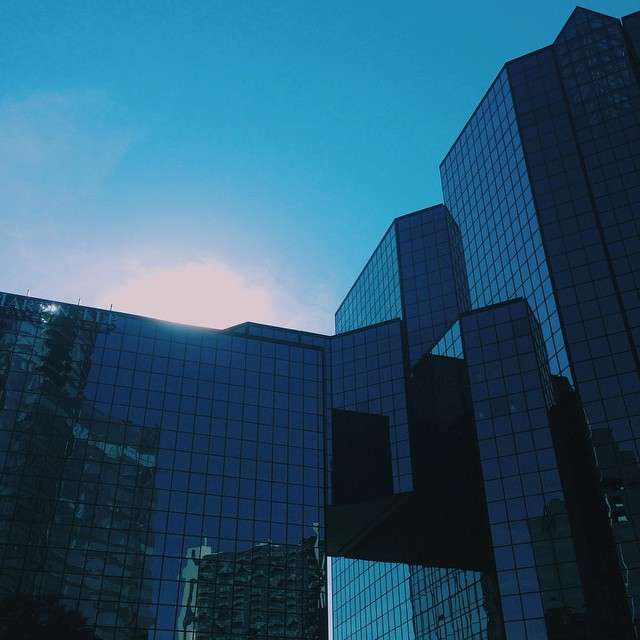

['weloveatl', 'vscocam', 'architecture', 'atl', 'vsco', 'atlanta']


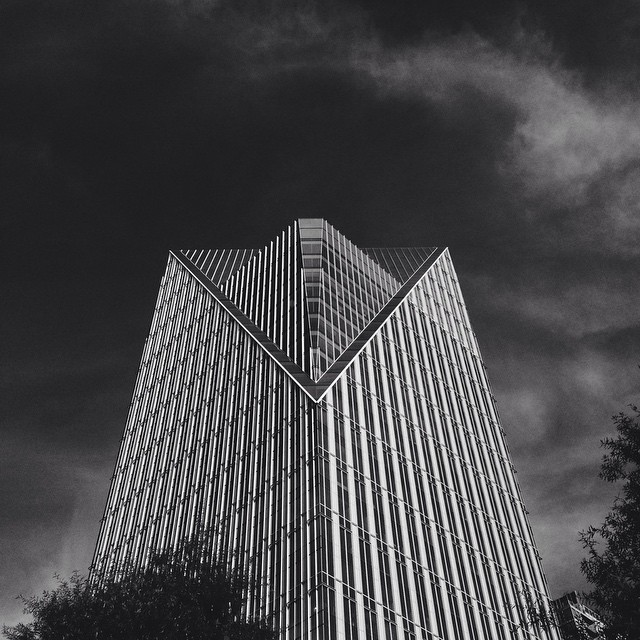

['weloveatl', 'vscocam', 'architecture', 'atl', 'vsco', 'atlanta']


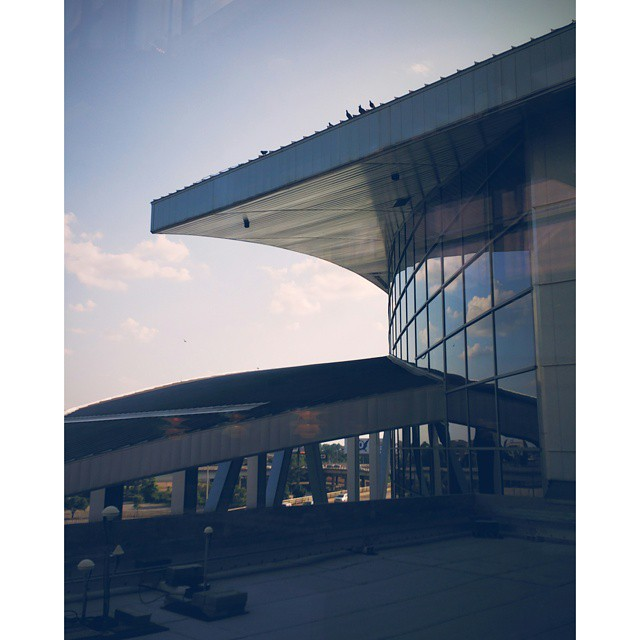

['weloveatl', 'georgia', 'igatlanta', 'atl', 'vscoatl', 'vsco', 'downtown', 'architecture', 'atlanta', 'vscocam']


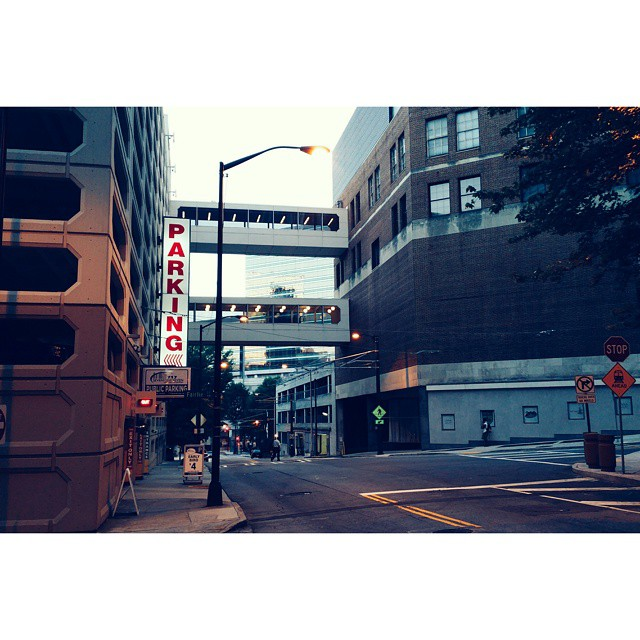

['weloveatl', 'georgia', 'igatlanta', 'atl', 'vscoatl', 'vsco', 'downtown', 'street', 'architecture', 'atlanta', 'vscocam']


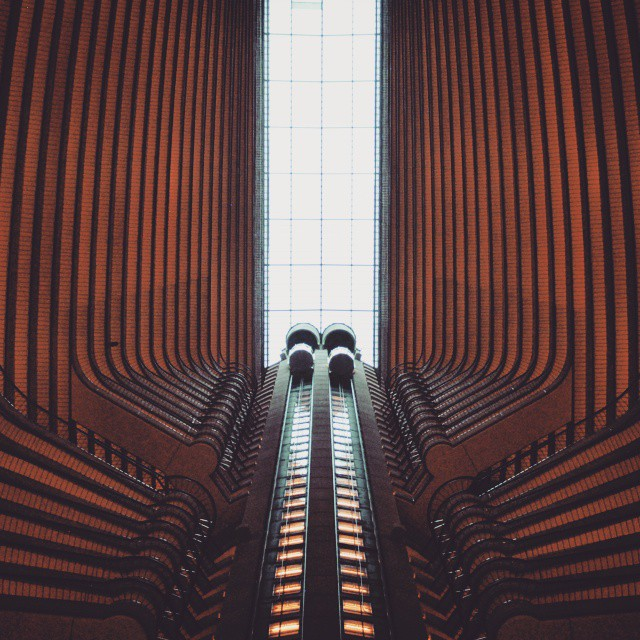

['weloveatl', 'streetshootersatl', 'atlanta', 'interiors', 'architecture']


In [20]:
import urllib
from IPython.display import Image, display

for i in range(len(top_results)):
    index=top_results.index[i]
    urllib.urlretrieve(top_results.pic_url[index], str(i)+'.jpg')
    display(Image(filename=str(i)+'.jpg'))
    print top_results.tags[index].split()

And there you have a simple application of hashtag similarity values. If you wanted to take things further, you could try...

* More complex similarity calculations and preprocessing
* Include follower, comment, and like counts into the scoring algorithm to find higher quality posts
* Recommend additional hashtags for an upcoming post based on those you plan on using

Or you could try applying these techniques to a completely different type of data. If they are applied correctly, similarity calculations can accomplish a lot in a wide variety of domains.